In [71]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import copy
import random
import importlib
import algos as al
import imageio

importlib.reload(al) 

<module 'algos' from 'e:\\WindyPostmanProblem\\algos.py'>

In [2]:
def initialize_edge_weights(graph):
    """Set all edge weights to 0 for visualization."""
    for u, v in graph.edges():
        graph[u][v]['weight'] = 0

In [3]:
def get_highest_degree_node(graph):
    """Return the node with the highest degree in the graph."""
    degrees = dict(graph.degree())
    return max(degrees, key=degrees.get)

In [4]:
def multiple_probabilistic_walks(graph, num_walks, steps):
    """Simulate multiple random walks on the weighted graph."""
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node

    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [graph[current_node][neighbor].get('weight', 1) for neighbor in neighbors]

            # Normalize weights to create probabilities
            probabilities = [weight / sum(weights) if sum(weights) != 0 else 1 / len(weights) for weight in weights]
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
    
    return snapshots 

In [23]:
G = al.generate_sf_graph(300)
al.add_weights_to_edges_from_dict(G,nx.pagerank(nx.line_graph(G)))


snapshots = multiple_probabilistic_walks(G, 15, 400)


Graph with 300 nodes and 376 edges


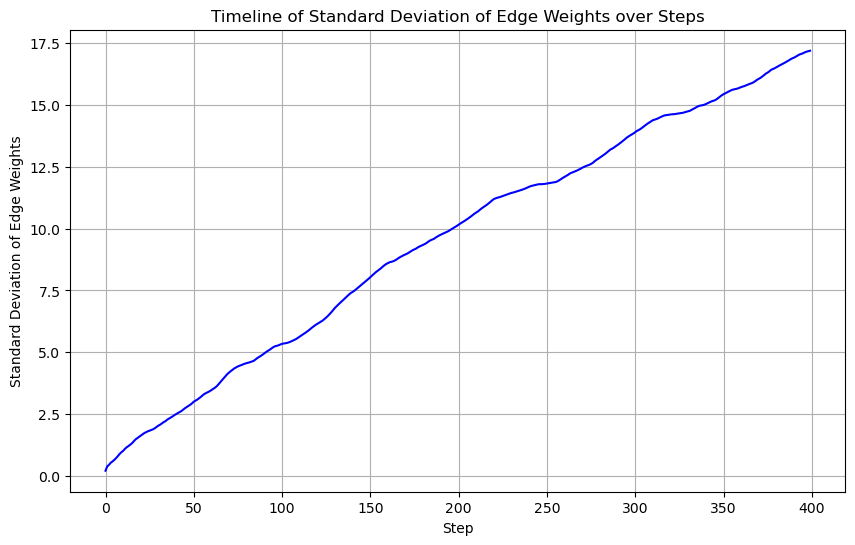

In [24]:

# List to store standard deviation of edge weights after each step
std_devs = []

# Calculate standard deviation for each snapshot
for snapshot in snapshots:
    edge_weights = [snapshot[u][v]['weight'] for u, v in snapshot.edges()]
    std_dev = np.std(edge_weights)
    std_devs.append(std_dev)

# Plotting the standard deviation timeline
plt.figure(figsize=(10, 6))
plt.plot(range(400), std_devs, linestyle='-', color='b')
plt.xlabel("Step")
plt.ylabel("Standard Deviation of Edge Weights")
plt.title("Timeline of Standard Deviation of Edge Weights over Steps")
plt.grid(True)
plt.show()

In [166]:
def compute_hybrid_weights(graph, alpha_degree, alpha_pagerank):
    """Compute edge weights based on a mix of Degree Centrality and PageRank of the line graph."""
    # Generate the line graph of the original graph
    line_graph = nx.line_graph(graph)
    
    # Compute PageRank and degree centrality on the line graph
    pagerank = nx.pagerank(line_graph)
    degree_centrality = nx.degree_centrality(line_graph)
    
    # Assign weights to the original graph's edges based on the line graph centralities
    for u, v in graph.edges():
        # Edges in the original graph correspond to nodes in the line graph
        edge_as_node = (u, v) if (u, v) in line_graph else (v, u)  # Handle undirected edge representation
        
        # Calculate combined centrality score based on the line graph node (edge in the original graph)
        combined_score = alpha_degree * degree_centrality[edge_as_node] + alpha_pagerank * pagerank[edge_as_node]
        graph[u][v]['weight'] = 1 / (combined_score + 1e-6)  # Small value to avoid division by zero

In [110]:

# Define ranges for alpha_degree and alpha_pagerank
alpha_degree_range = np.linspace(start = -10, stop=11,num=20)  # Adjust the range and step size as needed
alpha_pagerank_range = np.linspace(start = -10, stop=11,num=20)
steps = 400

In [137]:
std_devs = []
graph = al.generate_sf_graph(300)
# Iterate over combinations of alpha_degree and alpha_pagerank
for alpha_degree in alpha_degree_range:
    for alpha_pagerank in alpha_pagerank_range:
        graph_copy = copy.deepcopy(graph)  # Work on a copy of the graph to avoid overwriting weights
        compute_hybrid_weights(graph_copy, alpha_degree, alpha_pagerank)

        # Run the walk and calculate the standard deviation of edge weights
        snapshots = multiple_probabilistic_walks(graph_copy, 15, 200)
        final_snapshot = snapshots[-1]  # Snapshot after 400 steps
        edge_weights = [final_snapshot[u][v]['weight'] for u, v in final_snapshot.edges()]
        std_dev = np.std(edge_weights)
        
        # Store results for plotting
        std_devs.append((alpha_degree, alpha_pagerank, std_dev))

Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes and 377 edges
Graph with 300 nodes

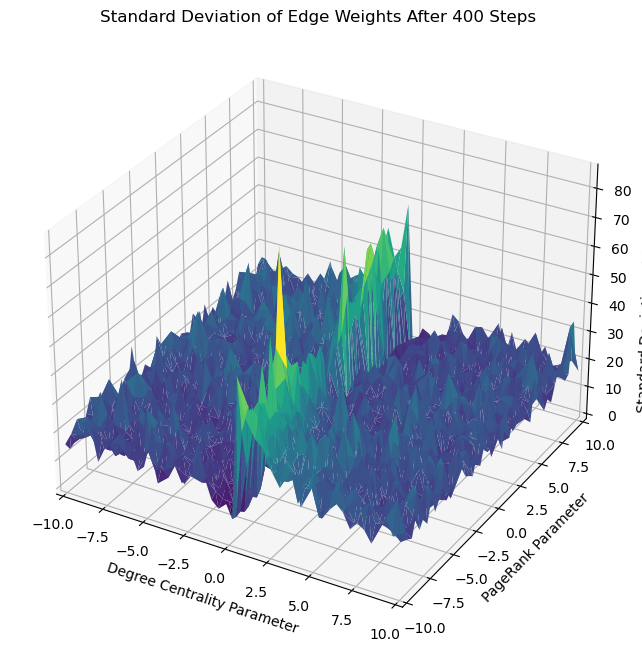

In [138]:
alpha_degree_vals, alpha_pagerank_vals, std_dev_vals = zip(*std_devs)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(alpha_degree_vals, alpha_pagerank_vals, std_dev_vals, cmap='viridis')

# Set axis limits to start from 0
ax.set_xlim(-10, max(alpha_degree_vals))
ax.set_ylim(-10, max(alpha_pagerank_vals))
ax.set_zlim(0, max(std_dev_vals))

# Axis labels and title
ax.set_xlabel("Degree Centrality Parameter")
ax.set_ylabel("PageRank Parameter")
ax.set_zlabel("Standard Deviation of Edge Weights")
ax.set_title("Standard Deviation of Edge Weights After 400 Steps")

plt.show()

In [139]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=alpha_degree_vals,
    y=alpha_pagerank_vals,
    z=std_dev_vals,
    mode='markers',
    marker=dict(
        size=5,
        color=std_dev_vals,  # Color by standard deviation values
        colorscale='Viridis',  # Color theme
        colorbar=dict(title="Standard Deviation")
    )
)])

# Add axis labels and title
fig.update_layout(
    scene=dict(
        xaxis_title="Degree Centrality Parameter",
        yaxis_title="PageRank Parameter",
        zaxis_title="Standard Deviation of Edge Weights"
    ),
    title="Interactive 3D Plot of Standard Deviation After 400 Steps",
)

# Display the int

In [157]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=alpha_degree_vals,
    y=alpha_pagerank_vals,
    z=std_dev_vals,
    mode='markers',
    marker=dict(
        size=5,
        color=std_dev_vals,  # Color by standard deviation values
        colorscale='Viridis',  # Color theme
        colorbar=dict(title="Standard Deviation")
    )
)])

# Add axis labels and title
fig.update_layout(
    scene=dict(
        xaxis_title="Degree Centrality Parameter",
        yaxis_title="PageRank Parameter",
        zaxis_title="Standard Deviation of Edge Weights"
    ),
    title="Interactive 3D Plot of Standard Deviation After 400 Steps",
    width=1000,  # Set the width of the plot
    height=800
)

# Display the int

In [141]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

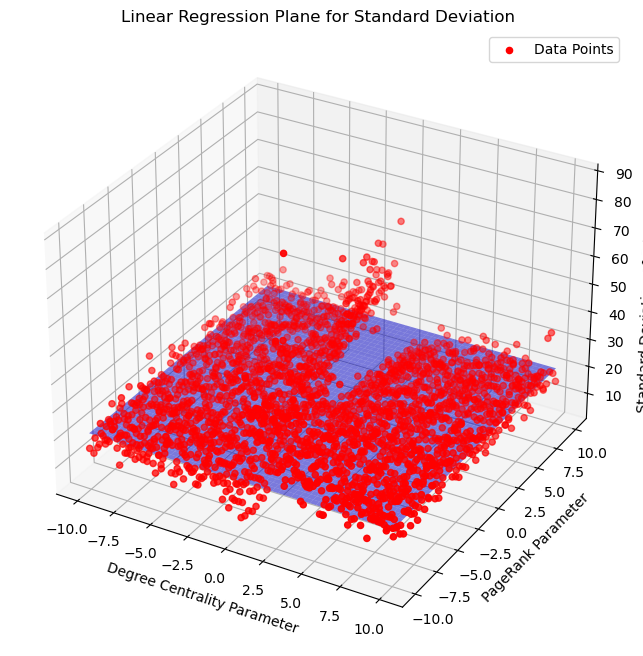

In [142]:
X = np.array(list(zip(alpha_degree_vals, alpha_pagerank_vals)))  # Features
y = np.array(std_dev_vals) 

model = LinearRegression()
model.fit(X, y)
alpha_degree_range = np.linspace(start = -10, stop=10,num=50)
alpha_pagerank_range = np.linspace(start = -10, stop=10,num=50)
alpha_degree_mesh, alpha_pagerank_mesh = np.meshgrid(alpha_degree_range, alpha_pagerank_range)

# Predict the standard deviation values for the mesh grid
Z = model.predict(np.c_[alpha_degree_mesh.ravel(), alpha_pagerank_mesh.ravel()])
Z = Z.reshape(alpha_degree_mesh.shape)

# Create a 3D plot with the regression plane
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points
ax.scatter(alpha_degree_vals, alpha_pagerank_vals, std_dev_vals, color='r', label='Data Points')

# Plot the regression plane
ax.plot_surface(alpha_degree_mesh, alpha_pagerank_mesh, Z, alpha=0.5, color='b')

# Add labels and title
ax.set_xlabel('Degree Centrality Parameter')
ax.set_ylabel('PageRank Parameter')
ax.set_zlabel('Standard Deviation of Edge Weights')
ax.set_title('Linear Regression Plane for Standard Deviation')

plt.legend()
plt.show()

In [143]:
std_dev_array = np.array(std_dev_vals)

# Find the index of the minimum standard deviation
min_index = np.argmin(std_dev_array)
max_index = np.argmax(std_dev_array)

# Retrieve the corresponding parameters
min_alpha_degree = alpha_degree_vals[min_index]
min_alpha_pagerank = alpha_pagerank_vals[min_index]
min_std_dev = std_dev_array[min_index]

max_alpha_degree = alpha_degree_vals[max_index]
max_alpha_pagerank = alpha_pagerank_vals[max_index]
max_std_dev = std_dev_array[max_index]


# Output the results
print(f"Minimum Standard Deviation: {min_std_dev}")
print(f"Parameters at Minimum: alpha_degree = {min_alpha_degree}, alpha_pagerank = {min_alpha_pagerank}")
print(f"Maximum Standard Deviation: {max_std_dev}")
print(f"Parameters at Maximum: alpha_degree = {max_alpha_degree}, alpha_pagerank = {max_alpha_pagerank}")

Minimum Standard Deviation: 6.431298006222895
Parameters at Minimum: alpha_degree = 0.204081632653061, alpha_pagerank = -8.775510204081632
Maximum Standard Deviation: 86.45756569359841
Parameters at Maximum: alpha_degree = 0.204081632653061, alpha_pagerank = -5.1020408163265305


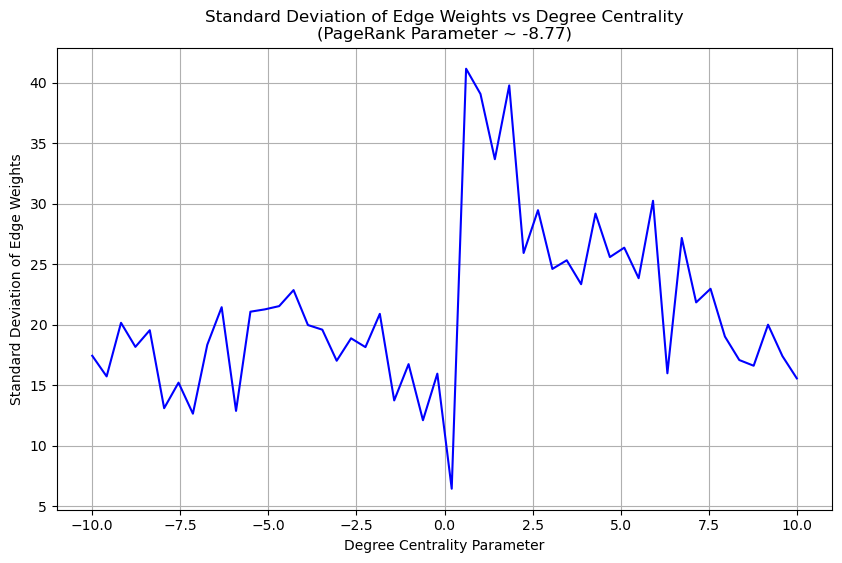

In [192]:
alpha_degree_vals = np.array(alpha_degree_vals)
alpha_pagerank_vals = np.array(alpha_pagerank_vals)
std_dev_vals = np.array(std_dev_vals)

# Set tolerance for filtering the PageRank parameter around -8.77
tolerance = 0.2
mask = np.isclose(alpha_pagerank_vals, -8.77, atol=tolerance)

# Apply the mask to filter degree centrality and standard deviation values
filtered_degree_vals = alpha_degree_vals[mask]
filtered_std_dev_vals = std_dev_vals[mask]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(filtered_degree_vals, filtered_std_dev_vals, linestyle='-', color='b')
plt.xlabel("Degree Centrality Parameter")
plt.ylabel("Standard Deviation of Edge Weights")
plt.title("Standard Deviation of Edge Weights vs Degree Centrality\n(PageRank Parameter ~ -8.77)")
plt.grid(True)
plt.show()

In [198]:
G = al.generate_sf_graph(300)
PR = copy.deepcopy(G)
Degree = copy.deepcopy(G)
Combined = copy.deepcopy(G)
UN = copy.deepcopy(G)
Max = copy.deepcopy(G)
al.add_weights_to_edges_from_dict(PR,nx.pagerank(nx.line_graph(G)))
al.add_weights_to_edges_from_dict(Degree,nx.degree_centrality(nx.line_graph(G)))
compute_hybrid_weights(Combined,0.25,-8.77)
#compute_hybrid_weights(Max,0.2,-5)
for u, v in UN.edges():
    UN[u][v]['weight'] = 1 



snapshots_PR = multiple_probabilistic_walks(PR, 15, 650)
snapshots_Degree = multiple_probabilistic_walks(Degree, 15, 650)
snapshots_Combined = multiple_probabilistic_walks(Combined, 15, 650)
snapshots_UN = multiple_probabilistic_walks(UN, 15, 650)
#snapshots_Max = multiple_probabilistic_walks(Max, 15, 650)

Graph with 300 nodes and 378 edges
Graph with 300 nodes and 378 edges
Graph with 300 nodes and 378 edges
Graph with 300 nodes and 378 edges


In [196]:
def compute_std_devs(snapshots):
    std_devs = []
    for snapshot in snapshots:
        # Extract edge weights
        weights = np.array([snapshot[u][v]['weight'] for u, v in snapshot.edges()])
        std_devs.append(np.std(weights))
    return std_devs

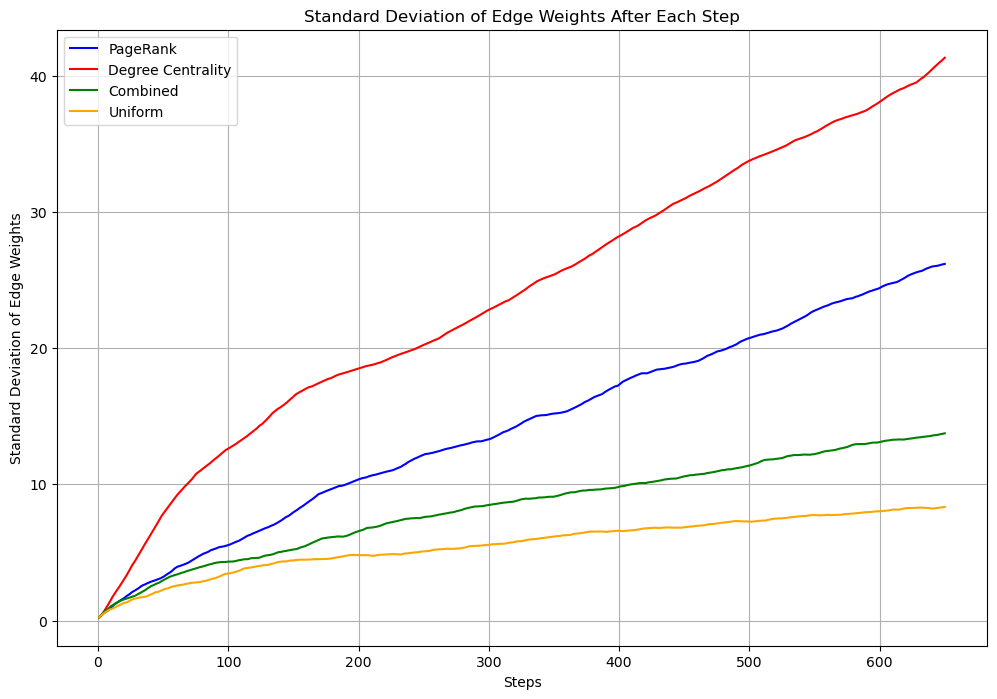

In [199]:
std_devs_PR = compute_std_devs(snapshots_PR)
std_devs_Degree = compute_std_devs(snapshots_Degree)
std_devs_Combined = compute_std_devs(snapshots_Combined)
std_devs_UN = compute_std_devs(snapshots_UN)
#std_devs_Max = compute_std_devs(snapshots_Max)

# Plotting the standard deviations
plt.figure(figsize=(12, 8))
steps = range(1, 651)  # Adjust for the number of steps

plt.plot(steps, std_devs_PR, label='PageRank', linestyle='-', color='b')
plt.plot(steps, std_devs_Degree, label='Degree Centrality', linestyle='-', color='r')
plt.plot(steps, std_devs_Combined, label='Combined', linestyle='-', color='g')
plt.plot(steps, std_devs_UN, label='Uniform', linestyle='-', color='orange')
#plt.plot(steps, std_devs_Max, label='Max', linestyle='-', color='black')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Standard Deviation of Edge Weights')
plt.title('Standard Deviation of Edge Weights After Each Step')
plt.legend()
plt.grid()
plt.show()

Animation saved as Degree_centrality.gif


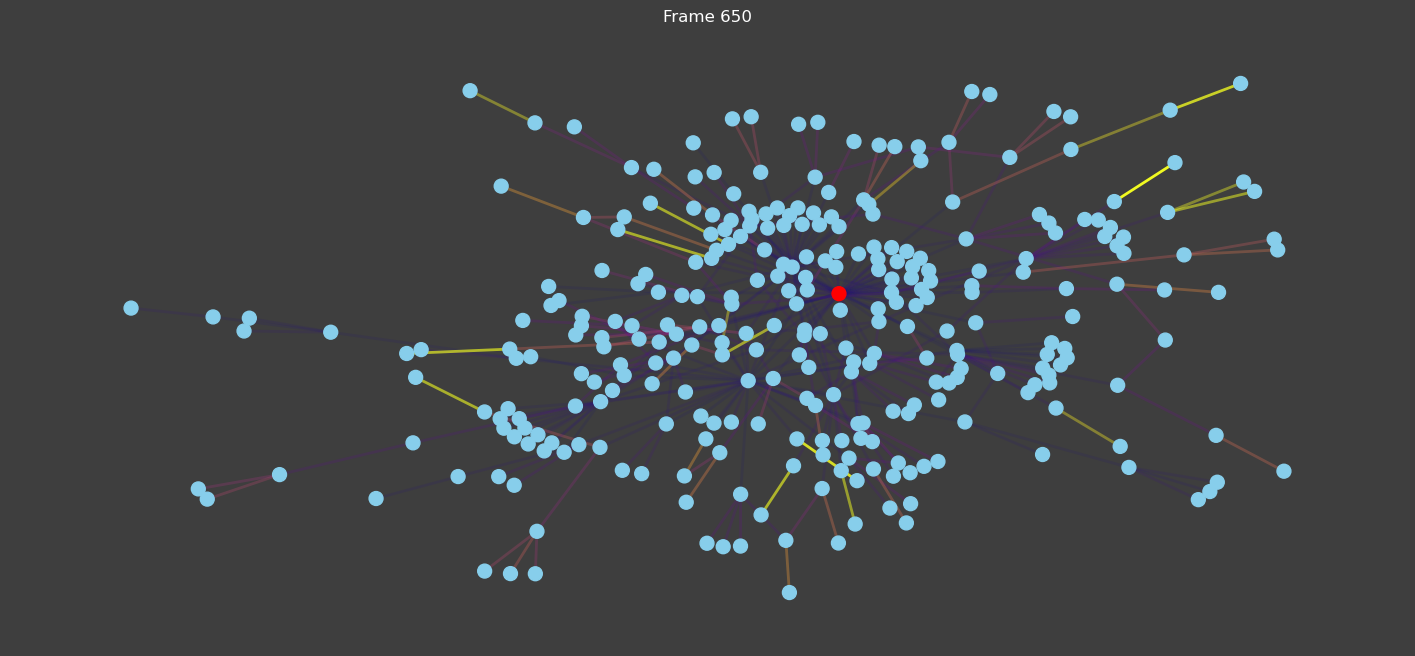

In [78]:
al.animate_walks(snapshots_Degree,  filename="Degree_centrality.gif",fps=30)

Animation saved as PageRank_centrality.gif


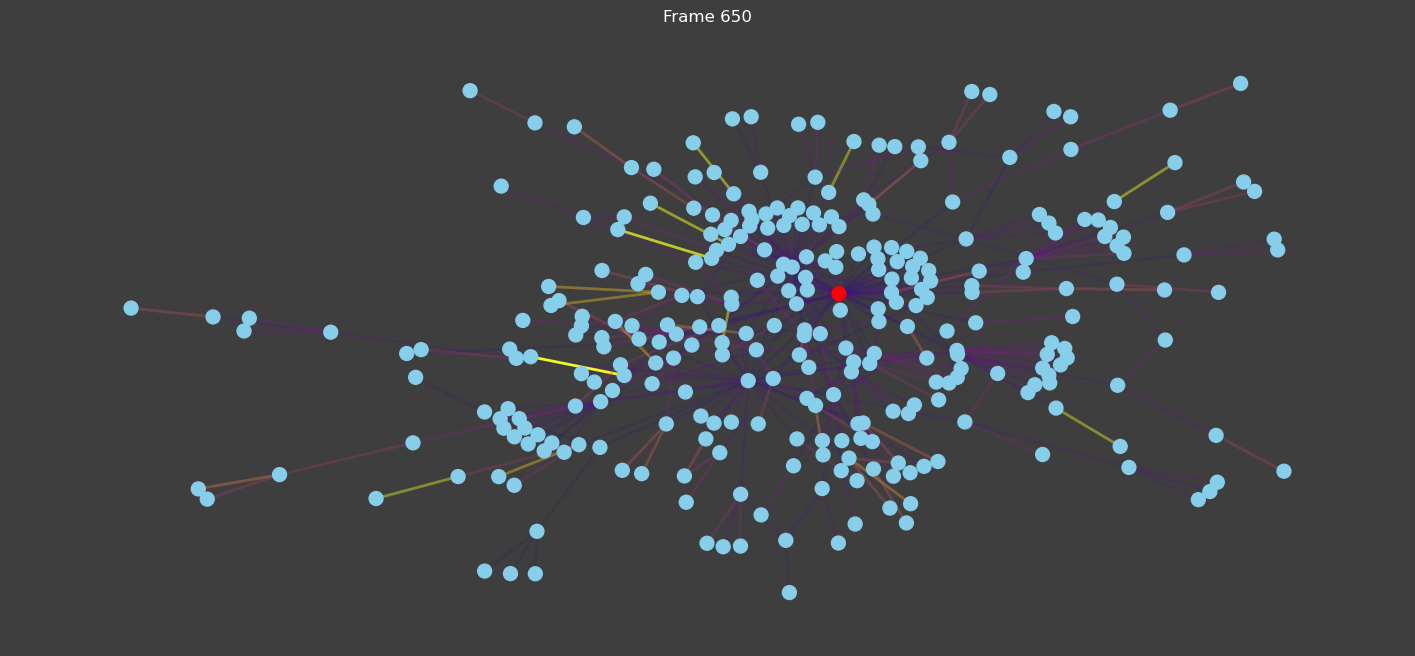

In [79]:
al.animate_walks(snapshots_PR,  filename="PageRank_centrality.gif",fps=30)


Animation saved as Combined_centrality.gif


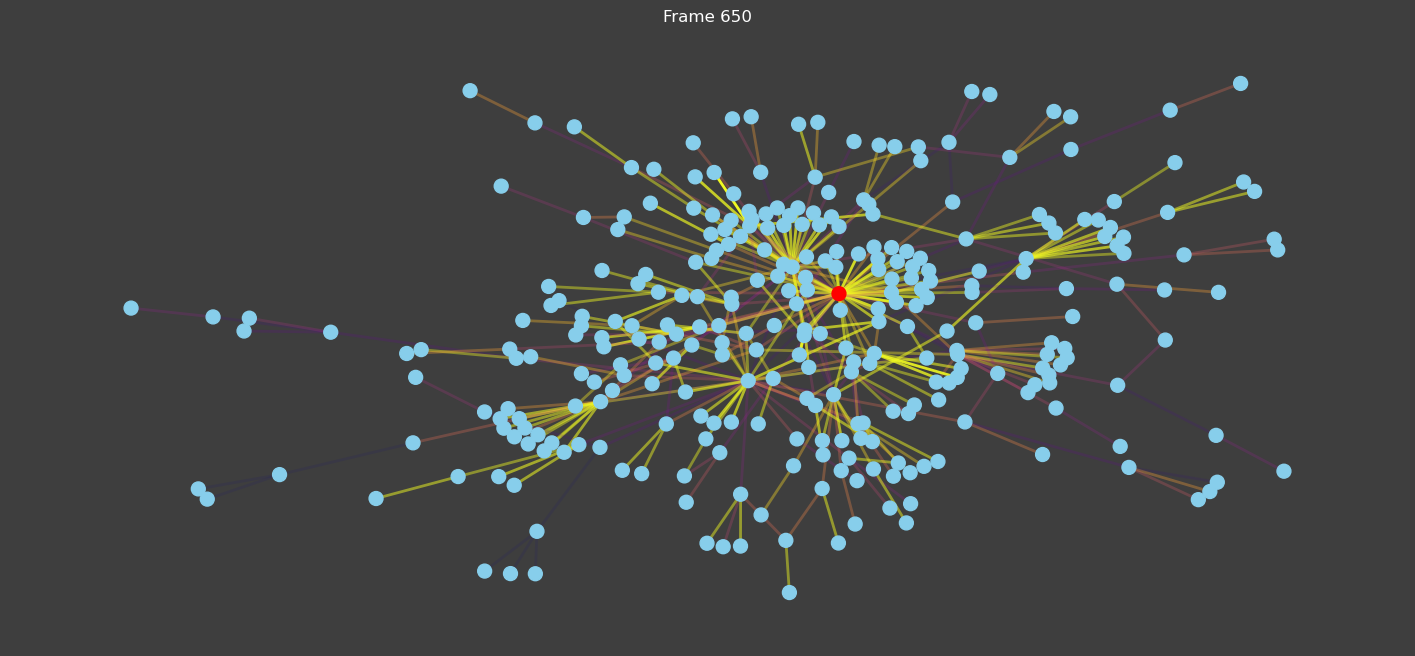

In [80]:
al.animate_walks(snapshots_Combined,  filename="Combined_centrality.gif",fps=30)


Animation saved as Uniform.gif


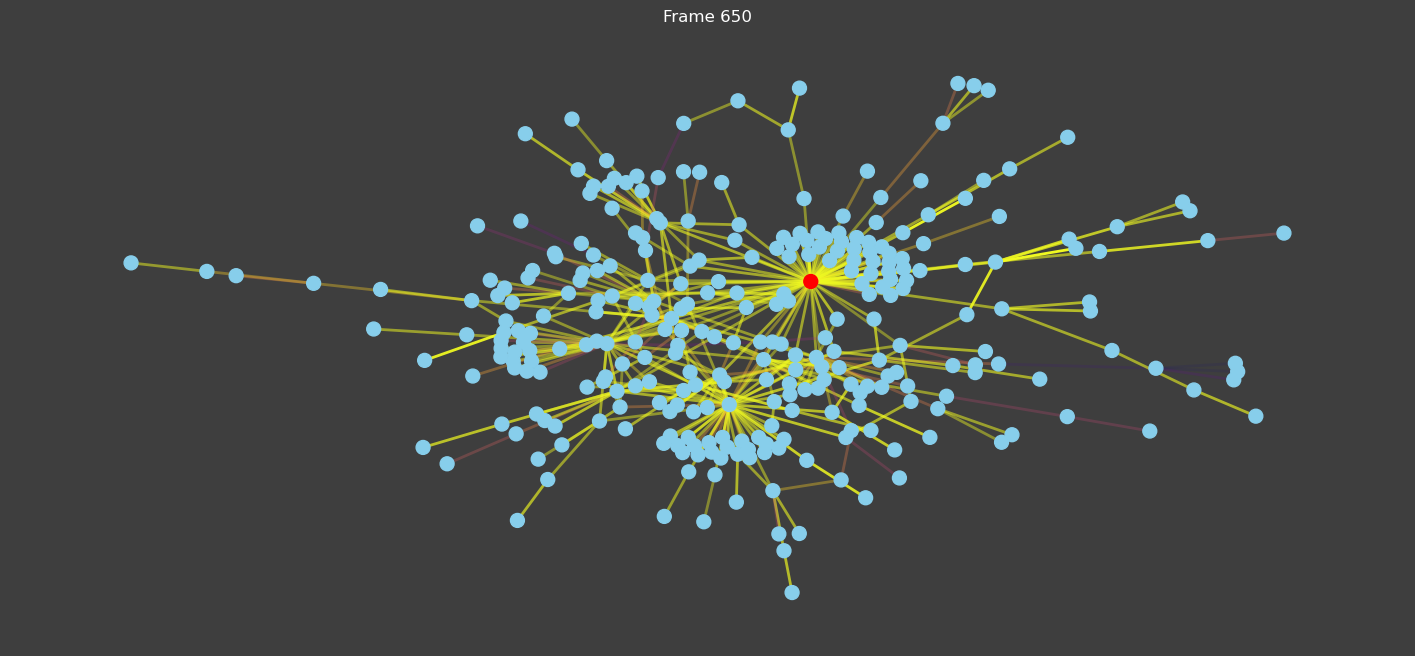

In [85]:
al.animate_walks(snapshots_UN,  filename="Uniform.gif",fps=30)


Animation saved as Max.gif


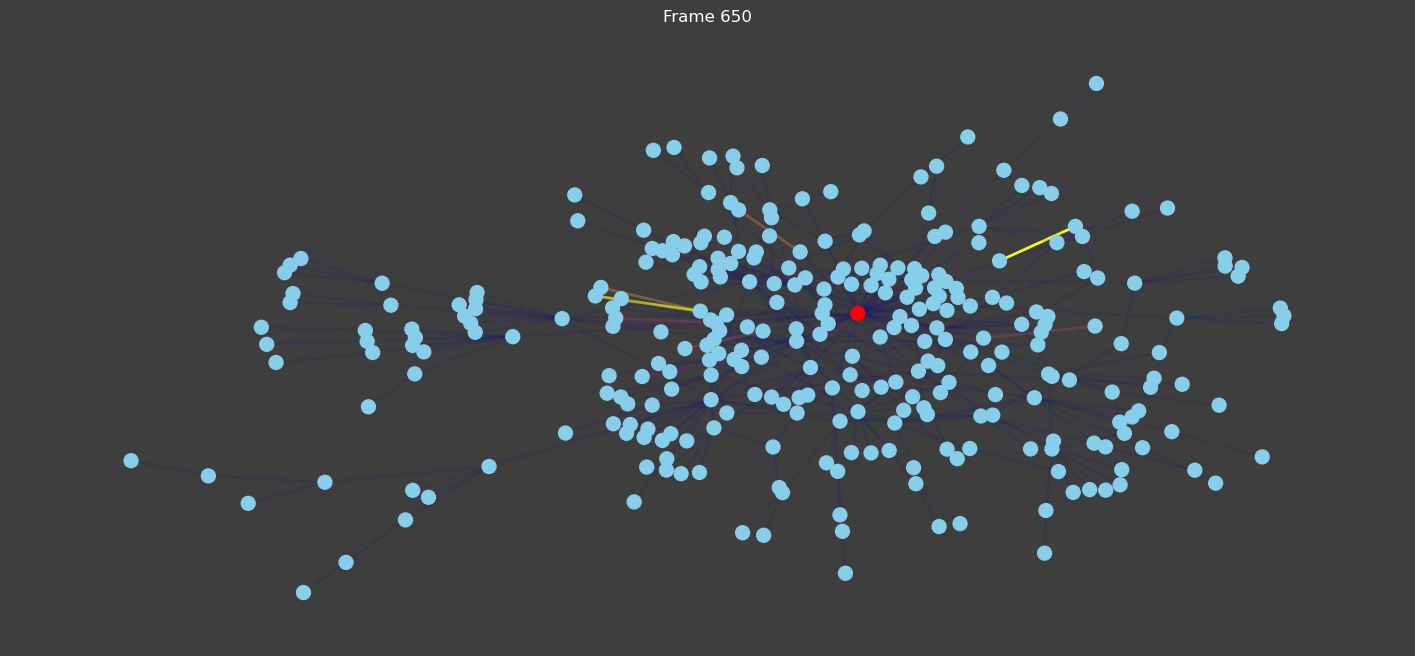

In [152]:
al.animate_walks(snapshots_Max,  filename="Max.gif",fps=30)


In [156]:
for u, v in snapshots_Combined[-1].edges():
    print(snapshots_Combined[-1][u][v]['weight'] )

20
23
13
24
8
15
17
18
17
23
10
20
18
17
20
24
29
25
20
20
42
19
36
17
21
21
36
36
22
34
36
30
16
42
38
32
30
24
29
32
32
36
28
26
32
38
32
15
28
32
14
7
9
14
12
20
16
14
24
22
14
16
12
20
22
14
20
22
30
20
18
23
27
20
26
18
32
21
8
9
13
8
12
12
18
12
10
17
20
7
15
22
16
24
6
10
27
14
10
20
12
16
16
14
12
6
13
15
24
12
28
16
14
13
27
27
27
26
22
20
4
42
22
33
28
34
40
8
6
22
14
20
6
14
11
20
14
17
12
11
22
28
33
24
16
6
12
8
4
4
10
8
4
13
22
22
19
14
13
19
18
22
18
32
18
42
16
19
23
26
19
38
13
39
40
6
6
11
10
20
7
10
16
20
26
38
28
64
35
26
19
20
20
24
11
12
26
12
20
20
18
42
22
21
9
8
16
20
8
18
10
14
10
16
10
20
18
20
14
19
25
82
15
34
40
28
16
20
50
46
53
60
70
72
13
26
32
70
18
30
8
27
24
32
22
28
60
60
54
28
36
12
42
22
50
48
24
53
14
12
10
12
49
26
34
24
18
18
17
34
36
30
16
28
45
36
28
14
38
78
23
20
8
26
32
14
10
9
30
30
30
18
34
52
46
36
39
34
32
14
23
12
60
22
28
42
58
21
50
38
16
35
46
90
14
29
24
24
28
26
28
32
40
42
208
44
46
31
66
11
18
18
10
26
6
14
8
16
24
36
48
40
112